This code was originally run on Kaggle.

Tensorflow Version: 2.2.0

Keras Version: 2.3.1

In [25]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import pandas as pd

start = time.time()

# Variables

In [13]:
## variables for the fiddling with

dim = (176,208)               # input image dimensions                                              (176,208)
#test_split_percent = .1       # % of total data for testing                                         .1
#validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 15                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD     

# Import Data From Local Drive

In [14]:
TRAIN_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"
TEST_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/"
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='constant', #fills extra space
        cval=0,               #with the color black
        brightness_range=bright_range, #randomly lightens or darkens image, values less than 1 darken
        zoom_range=zoom,               #randomly zooms in or out, values less than 1 zoom in
        data_format='channels_last',   #example: train_data.shape = (1521, 4) instead of (4, 1521)
        zca_whitening=False)           #zca_whitening = linear algebra operation that highlights structure and function, 
                                       #doesn't make sense for our case because general brain structure is the same for all cases

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255,
                                  fill_mode='constant',
                                  cval=0,
                                  zoom_range=[1,1], #no zoom
                                  data_format='channels_last')

# this is a generator that will read pictures found in
# subfolders of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        directory = TRAIN_DIR,  # this is the target directory
        target_size=dim,  # all images will be resized to 176x208
        batch_size = 5121)

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        directory = TEST_DIR,
        target_size=dim,  # all images will be resized to 176x208
        batch_size = 1279,
        shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [15]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_generator.next()
test_data,test_labels = test_generator.next()

# val_data,val_labels = val_data_gen.next()

# Sanity Check

In [16]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(5121, 176, 208, 3)
(1279, 176, 208, 3)
(5121, 4)
(1279, 4)


# Showing Some Image Examples

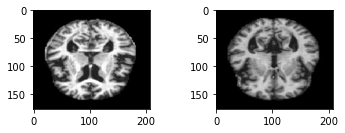

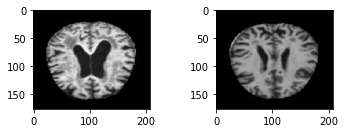

In [17]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [18]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))

1.0
0.0


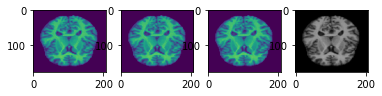

In [19]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model

In [20]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

58892288/58889256 [==============================] - 1s 0us/step


In [21]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # prevents overfitting
output = Dense(4,activation='softmax')(dp1)                                # kept softmax because it's multiclass classification
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

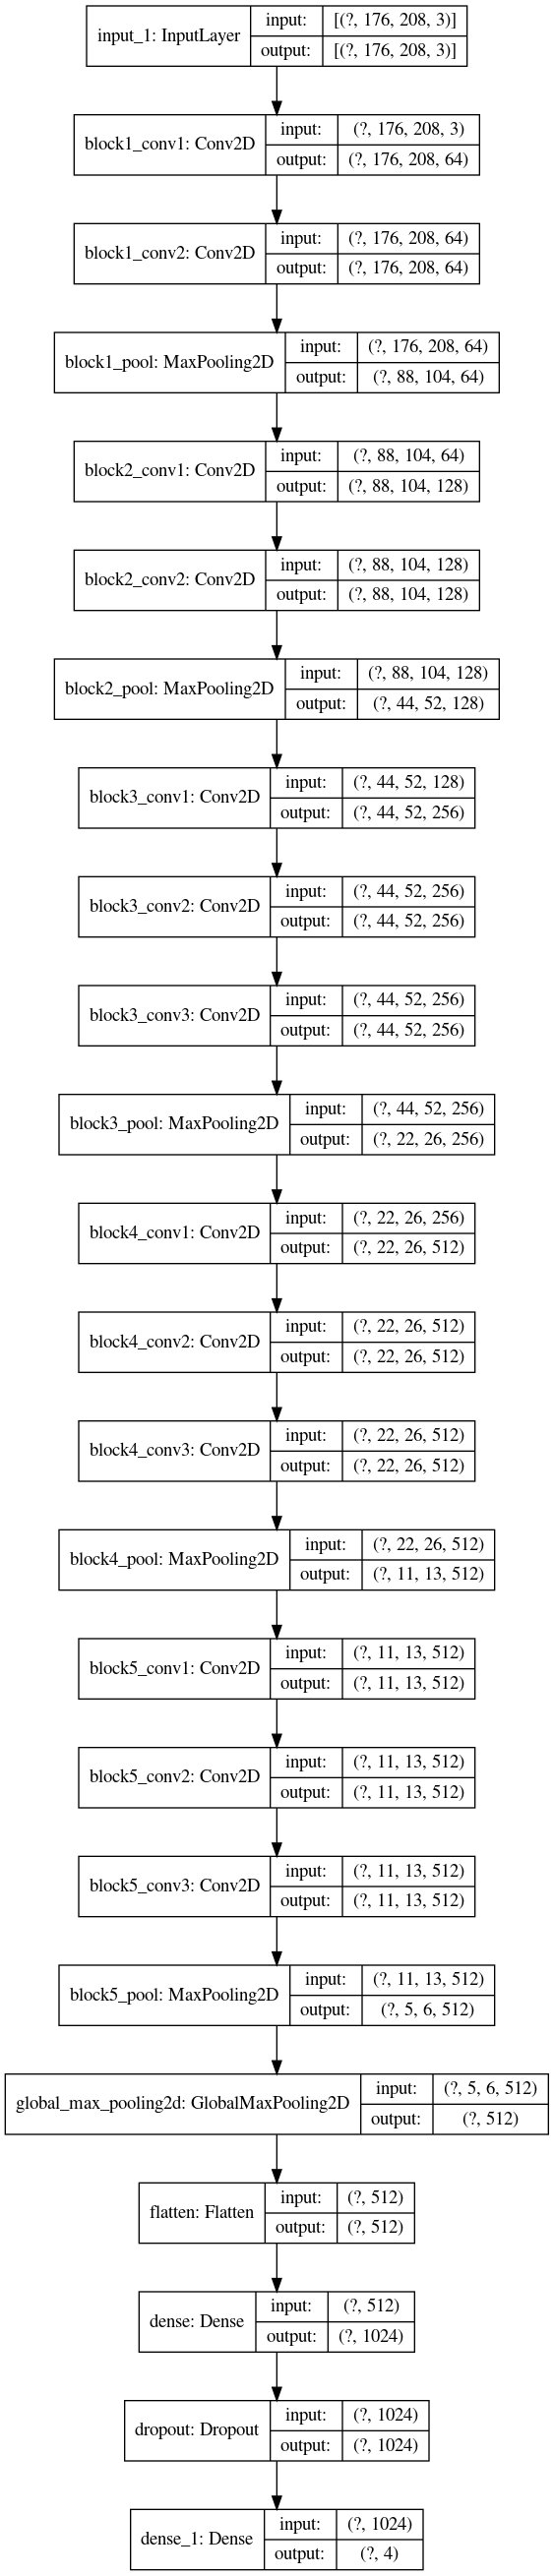

In [26]:
#visualize model
plot_model(vg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train the Model



In [13]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(test_data,test_labels),
                             epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/15
257/257 [==============================] - 38s 149ms/step - loss: 1.0097 - accuracy: 0.5310 - val_loss: 1.0960 - val_accuracy: 0.5027
Epoch 2/15
257/257 [==============================] - 37s 144ms/step - loss: 0.8275 - accuracy: 0.6290 - val_loss: 0.8673 - val_accuracy: 0.6091
Epoch 3/15
257/257 [==============================] - 37s 144ms/step - loss: 0.6939 - accuracy: 0.7088 - val_loss: 1.1538 - val_accuracy: 0.5723
Epoch 4/15
257/257 [==============================] - 37s 144ms/step - loss: 0.5759 - accuracy: 0.7602 - val_loss: 0.9962 - val_accuracy: 0.5770
Epoch 5/15
257/257 [==============================] - 37s 145ms/step - loss: 0.4344 - accuracy: 0.8299 - val_loss: 1.7605 - val_accuracy: 0.5192
Epoch 6/15
257/257 [==============================] - 37s 144ms/step - loss: 0.3379 - accuracy: 0.8696 - val_loss: 1.1586 - val_accuracy: 0.6349
Epoch 7/15
257/257 [==============================] - 37s 144ms/step - loss: 0.2100 - accuracy: 0.9244 - val_loss: 1.2803 - val_ac

# Plots and Values

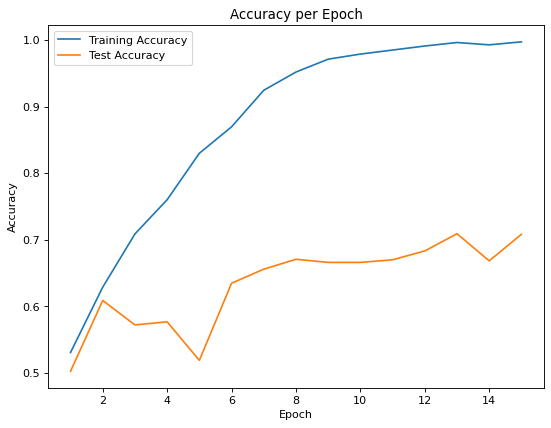

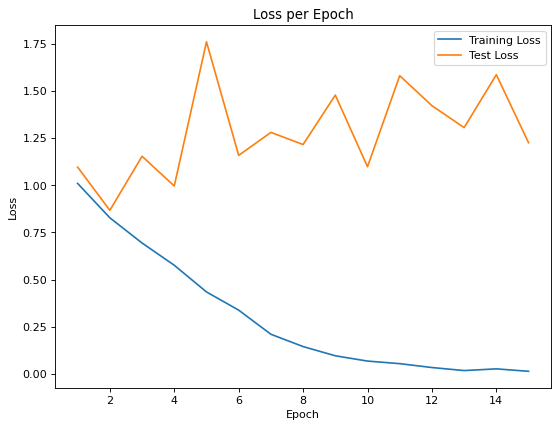

image dimensions:  (176, 208)
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  20
epochs:  15
brightness range:  [0.8, 1.2]
Model trained from scratch? :  True
Total Time Elapsed = 24 minutes


In [15]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# print(np.amax.model_history.history['val_acc'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Performance Evaluation

In [16]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 3s 75ms/step - loss: 1.2255 - accuracy: 0.7084
Train Accuracy: 99.63%
Test Accuracy: 70.84%


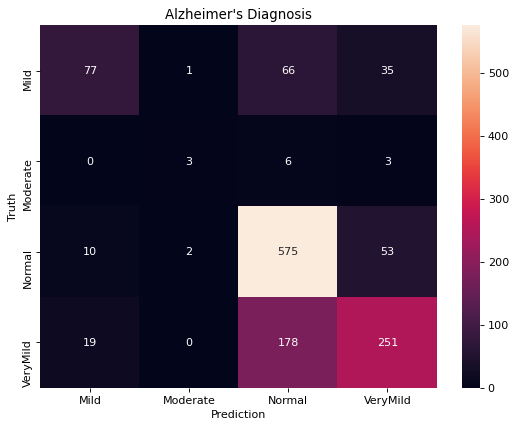

In [17]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)

# Saving the Model

In [23]:
#uncomment if you want to save model
'''
## saving in HDF5 format
    
save_model_name = "testsplit%2d_epochs%d"%(0.2*100,eps)   # automatically generate a model save name
print(save_model_name)

save_name = '%s_testacc%2d.h5'%(save_model_name,(test_scores[1]*100))
vg_model.save('/kaggle/working/%s'%save_name)
print(save_name)


# ## save the model_history
'''

testsplit20_epochs15
testsplit20_epochs15_testacc70.h5
